In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cloudmesh.common.StopWatch import StopWatch
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import pathlib
from pathlib import Path

In [17]:
cryptoName = input('Please enter the name of the crypto to predict.\nExamples include "EOS-USD", "DOGE-USD",\n"ETH-USD", and "BTC-USD" without double quotes')
print(cryptoName+' selected')


EOS-USD selected


In [18]:
StopWatch.start("Overall time")

# Creating desktop path to save figures to the desktop
desktop = pathlib.Path.home() / 'Desktop'
desktop2 = str(Path(desktop))
fullpath = desktop2 + "\\"+cryptoName+"-prediction-model.png"
fullpath2 = desktop2 + "\\"+cryptoName+"-prediction-model-zoomed.png"
fullpath3 = desktop2 + "\\"+cryptoName+"-price.png"
fullpath4 = desktop2 + "\\"+cryptoName+"-training-loss.png"


register_matplotlib_converters()

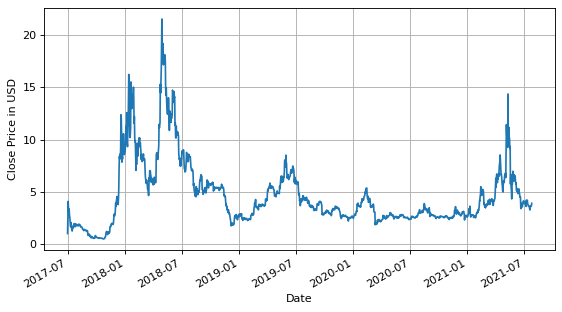

In [19]:
ticker = yf.Ticker(cryptoName)
data = ticker.history(period = "15y", interval = "1d")

# Sort the dataframe according to the date
data.sort_values('Date', inplace=True, ascending=True)

# Print the dataframe top
data.head()

# Visualization of data. Plotting the price close.
plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
data['Close'].plot()
plt.tight_layout()
plt.grid()
plt.ylabel('Close Price in USD')
plt.xlabel('Date')
plt.savefig(fullpath3, dpi=100, facecolor="#FFFFFF")
plt.show()

In [20]:
print(data.index[0])
firstDate = data.index[0]
firstDateFormatted = pd.to_datetime(data.index[0], utc=False)
print(firstDateFormatted)
date_time_obj = firstDateFormatted.to_pydatetime()
trueFirstDate = date_time_obj.strftime('%m/%d/%Y')
print(trueFirstDate)


2017-07-01 00:00:00
2017-07-01 00:00:00
07/01/2017


In [21]:
print(data.head())


                Open     High       Low    Close     Volume  Dividends  \
Date                                                                     
2017-07-01  1.031340  1.07176  0.989566  1.00669   13613000          0   
2017-07-02  0.996521  2.87751  0.822648  2.71005  320452000          0   
2017-07-03  2.717390  5.39597  2.632310  4.08664  414950016          0   
2017-07-04  4.098010  4.19124  2.933450  3.37200  218559008          0   
2017-07-05  3.356000  3.52350  2.730130  3.00323  124339000          0   

            Stock Splits  
Date                      
2017-07-01             0  
2017-07-02             0  
2017-07-03             0  
2017-07-04             0  
2017-07-05             0  


In [22]:
# Get Close data
df = data[['Close']].copy()
# Split data into train and test
train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

print(len(train), len(test))

1283 200


In [23]:
train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

In [24]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 10

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

In [25]:
StopWatch.start("Training time")

model = keras.Sequential()
model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=False
)

StopWatch.stop("Training time")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 250)               252000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40/40 [==============================] - 1s 7ms/step - loss: 0.0459

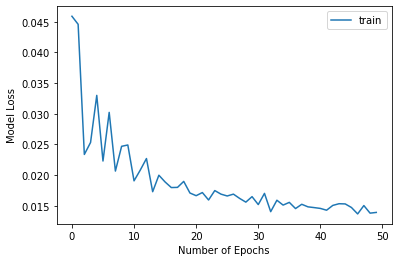

In [26]:
# Plotting the loss
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.ylabel('Model Loss')
plt.xlabel('Number of Epochs')
plt.savefig(fullpath4, dpi=100, facecolor="#FFFFFF")
plt.show()

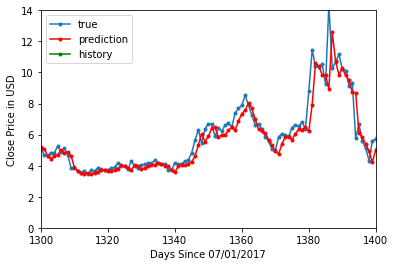

In [27]:
StopWatch.start("Prediction time")

y_pred = model.predict(X_test)

StopWatch.stop("Prediction time")

# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Close Price in USD')
plt.xlabel('Days Since '+trueFirstDate)
plt.legend()
plt.savefig(fullpath, dpi=100, facecolor="#FFFFFF")
plt.axis([1300, 1400, 0, 14])
plt.savefig(fullpath2, dpi=100, facecolor="#FFFFFF")
plt.show()


In [28]:
print(y_test.shape)
print(y_pred.shape)


(190,)
(190, 1)


In [29]:
## Outputs error in United States Dollars
mean_squared_error(y_test, y_pred)

## Create a table of the error against the number of epochs

0.4848590794434403

In [30]:
StopWatch.stop("Overall time")
StopWatch.benchmark()


+------------------+--------------------------------------------------------------------------------+
| Attribute        | Value                                                                          |
|------------------+--------------------------------------------------------------------------------|
| cpu              |                                                                                |
| cpu_cores        | 6                                                                              |
| cpu_count        | 12                                                                             |
| cpu_threads      | 12                                                                             |
| frequency        | scpufreq(current=3600.0, min=0.0, max=3600.0)                                  |
| mem.available    | 7.1 GiB                                                                        |
| mem.free         | 7.1 GiB                                                     